# Javanese Hate Speech Twitter Dataset

Data comes from the paper [Abusive Language and Hate Speech Detection for Javanese and
Sundanese Languages in Tweets: Dataset and Preliminary Study](http://www.wcse.org/WCSE_2021_Spring/011.pdf). The dataset has three columns:
- `isi_tweet`: the tweet text
- `uk`: binary label for abusive language
- `hs`: binary label for hate speech

We consolidate the two labels into one column `label` and use the Label Powerset method to convert the multi-label problem into a multi-class problem, following the paper. The new labels are as follows:
- `0`: non-abusive, non-hate speech
- `1`: abusive, non-hate speech
- `2`: abusive, hate speech
- `3`: non-abusive, hate speech

Note that the Javanese dataset has no examples of non-abusive, hate speech, so there are only 3 classes.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
# Convert multiple binary columns to single mulitclass column
javanese = pd.read_csv('data/Javanese.csv').rename(columns={'isi_tweet':'sentence'})
javanese['label'] = javanese['uk'] + javanese['hs'] +  2 * ((1 - javanese['uk']) * javanese['hs'])
javanese = javanese[['sentence', 'label']]

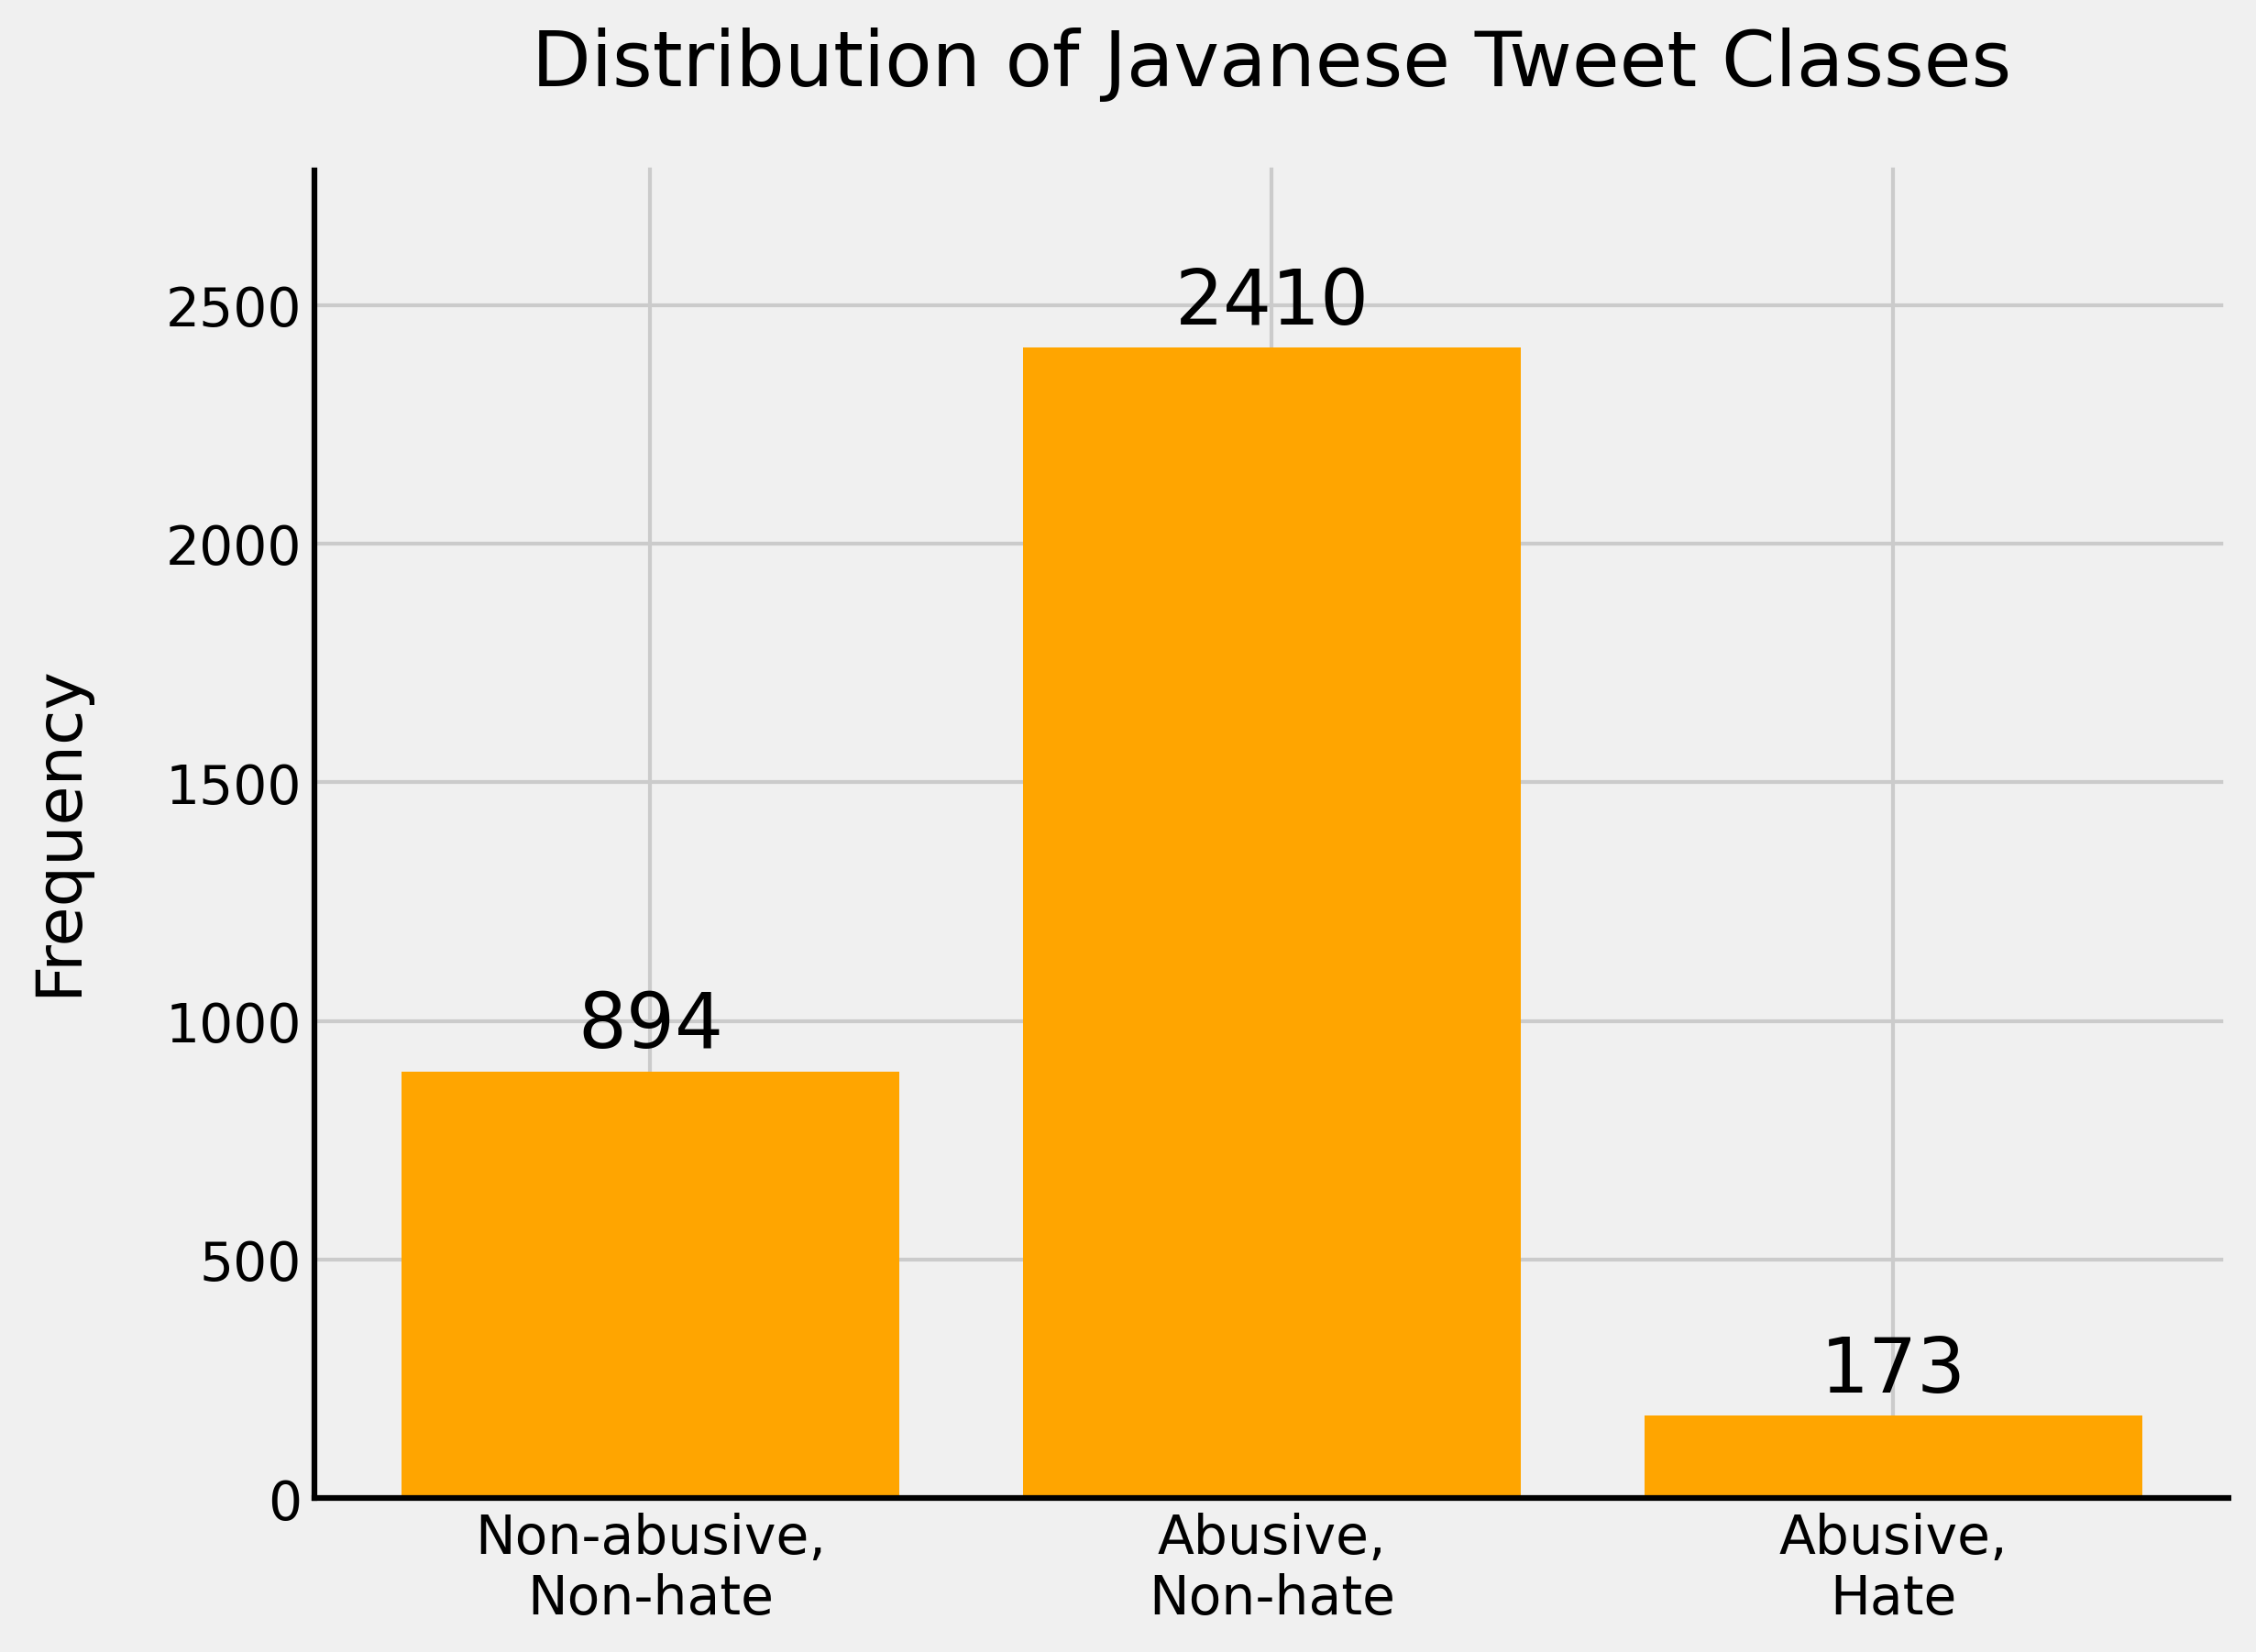

In [10]:
# Plot Javanese tweet class distribution
x_labels = ['Non-abusive,\nNon-hate', 'Abusive,\nNon-hate', 'Abusive,\nHate']
all_labels = [0, 1, 2]
label_counts_javanese = javanese['label'].value_counts().reindex(all_labels, fill_value=0)

plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, label_counts_javanese, color='orange')
plt.title('Distribution of Javanese Tweet Classes', pad=20)
plt.ylabel('Frequency', labelpad=20)
plt.ylim(0, 2800)
for bar in bars:
    plt.annotate(format(bar.get_height(), '.0f'), 
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='center', size=20, 
                       xytext=(0, 12), textcoords='offset points')
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/class_distribution.png', bbox_inches='tight', transparent=True)

## Converting to JSON

For each dataset, we create a JSON file with the following entries:
```
{"sentence":"pekok tu aph'","label":0}
```

In [6]:
def dataframe_to_json(dataframe, output_file):
    """ Convert dataframe to JSON format.
    """
    dataframe_json = dataframe.to_json(orient='records', lines=True)
    with open(output_file, 'w') as file:
        file.write(dataframe_json)


def prepare_data(df, output_pref):
    """ Split data into train, test, and dev set with stratified 5-fold cross-validation. 
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    i = 1
    for train_index, test_index in skf.split(df, df['label']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        test_df, dev_df = train_test_split(test_df, test_size=0.50, random_state=42, stratify=test_df['label'])
        save_dir = output_pref + f'fold{i}/'
        os.makedirs(save_dir, exist_ok=True)
        dataframe_to_json(train_df, save_dir + 'train.json')
        dataframe_to_json(test_df, save_dir + 'test.json')
        dataframe_to_json(dev_df, save_dir + 'dev.json')
        i += 1


prepare_data(javanese, 'data/')